Results:
- we subsetted Ag1000g P2 (1142 samples) zarr to the positions of the amplicon inserts
- a total of 1417 biallelic SNPs were observed in all samples, only one amplicon (29) did not have variation
- we performed PCA directly on those SNPs without LD pruning
- PCA readily splits Angolan samples `AOcol` and general gambiae vs coluzzii
- populations `GW`, `GAgam`, `FRgam` and some outliers of `CMgam` can be separated
- overall, resolution of clusters is less complete than in whole-genome dataset: https://github.com/malariagen/ag1000g-phase2-data-paper/blob/master/notebooks/figure_PCA.ipynb
- impacts of individual amplicons are different. Highest impact amplicons are 28, 60, 7.  

In [1]:
%run common.ipynb

In [2]:
# long population names
samples['population'] = samples.population.replace(pop_labels)

In [3]:
# concatenate biallelic site nalts into single array
ampl_flt = dict()
for ampl in callset:
    flt = callset[ampl]['biallelic'][:]
    nalt = callset[ampl]['NALT'][:]
    ampl_flt[ampl] = nalt[flt]
ampl_flt_nalts = np.concatenate([ampl_flt[ampl] for ampl in callset])
ampl_flt_nalts.shape

(1417, 1142)

## Alternative PCA for Kenya

In [4]:
# country_filter = samples.population.isin(['KE','GW'])
# country_filter.value_counts()
# samples = samples[country_filter]

In [5]:
# read all SNPs
# ampl_snps = dict()
# for ampl in callset:
#     ampl_snps[ampl] = callset[ampl]['genotype']
# cat_snps = allel.GenotypeChunkedArray(np.concatenate(list(ampl_snps.values())))

In [6]:
# subset to countries
# cat_snps = cat_snps[:, country_filter]

In [7]:
# recalculate biallelic nalts
# ac = cat_snps.count_alleles()
# flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
# ampl_flt_nalts = cat_snps[flt].to_n_alt()

## PCA

In [8]:
# skip ld_prune, straight to PCA
coords, model = allel.pca(ampl_flt_nalts, n_components=20, scaler='patterson')

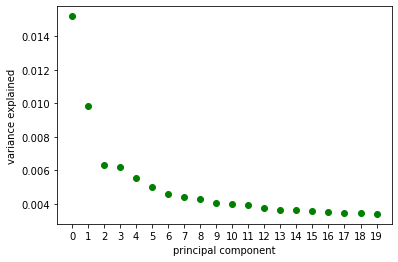

In [9]:
fig, ax = plt.subplots()
ax.plot(model.explained_variance_ratio_, 'go')
ax.set_xlabel("principal component")
ax.set_ylabel("variance explained")
plt.xticks(np.arange(0,20, 1));

In [10]:
# add first 12 pc values to samples table
for component in range(12):
    samples['pc{}'.format(component + 1)] = coords[:, component]
samples.head()

,ox_code,src_code,population,country,region,contributor,contact,year,m_s,sex,...,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12
0,AA0040-C,Twifo_Praso__E2,Ghana $coluzzii$,Ghana,Twifo_Praso,David Weetman,NaN,2012.0,M,F,...,0.053007,-2.628282,4.917352,-1.650977,-1.846985,4.992600,-1.690202,1.049989,-1.177348,1.586056
1,AA0041-C,Twifo_Praso__H3,Ghana $coluzzii$,Ghana,Twifo_Praso,David Weetman,NaN,2012.0,M,F,...,-4.115274,-0.202278,-1.080584,1.689047,0.261757,0.289455,1.719841,-0.155459,0.537245,0.009427
2,AA0042-C,Takoradi_C7,Ghana $coluzzii$,Ghana,Takoradi,David Weetman,NaN,2012.0,M,F,...,-2.725425,-3.672296,2.094174,-5.466596,-0.572769,1.237521,-2.391268,-1.043326,-1.171342,1.451998
3,AA0043-C,Takoradi_H8,Ghana $coluzzii$,Ghana,Takoradi,David Weetman,NaN,2012.0,M,F,...,-2.647307,-2.548321,2.362399,-2.309045,-1.080733,-0.138139,-0.240974,-0.854244,-2.078220,1.001149
4,AA0044-C,Takoradi_D10,Ghana $coluzzii$,Ghana,Takoradi,David Weetman,NaN,2012.0,M,F,...,-0.582114,-0.918370,2.157809,-2.311575,-1.079385,1.629897,-1.931826,1.411253,-0.919504,2.194630


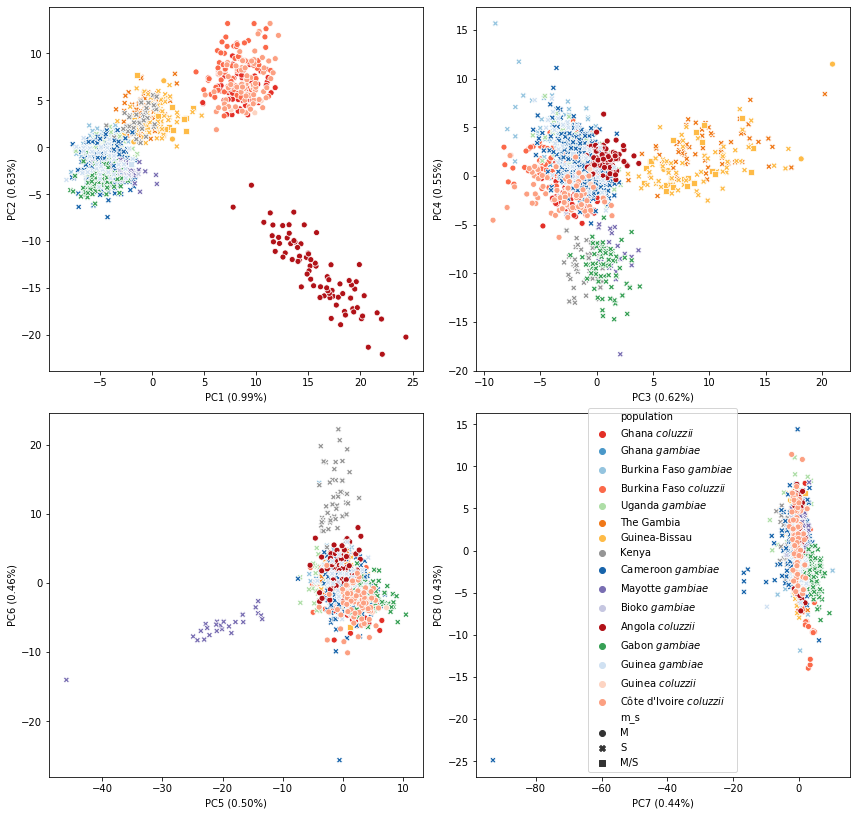

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    comp1 = i*2 + 1
    comp2 = i*2 + 2
    pc_var1 = model.explained_variance_ratio_[comp1] * 100
    pc_var2 = model.explained_variance_ratio_[comp2] * 100
    legend = ('full' if i==3 else False)    
    g = sns.scatterplot(data=samples, 
                    x='pc{}'.format(comp1), 
                    y='pc{}'.format(comp2), 
                    hue='population',
                    style='m_s',
                    palette=pop_colors,
                    legend=legend, 
                    ax=ax);
    # attempt to place legend outside
    # g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    ax.set_xlabel('PC{} ({:.2f}%)'.format(comp1, pc_var1))
    ax.set_ylabel('PC{} ({:.2f}%)'.format(comp2, pc_var2));
plt.tight_layout()

## Impact of individual amplicons on PCA

In [12]:
# extract PCA component coefficients
components = pd.DataFrame(model.components_.T, 
                          columns=range(1,21)) #.abs()
components.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,-0.007095,-0.000923,-0.005186,0.014606,-0.016477,0.000644,0.001844,0.015901,0.013426,-0.024026,-0.028253,0.003773,-0.023500,-0.008928,0.001717,0.005247,0.003948,-0.009200,0.015280,-0.004124
1,-0.001609,0.003901,-0.007648,-0.003132,0.011961,-0.011989,-0.002622,0.014302,-0.015754,0.004119,-0.004084,0.009420,0.008757,0.013099,-0.013740,-0.014687,0.002399,0.003736,0.005583,-0.006725
2,-0.010870,-0.000708,-0.020767,0.000796,0.010791,-0.010006,0.007413,-0.005026,0.020582,-0.008738,0.006891,0.015928,-0.007783,-0.026001,-0.001846,0.016224,-0.018843,0.003642,0.056912,0.011077
3,0.013284,0.014437,-0.005704,-0.006074,-0.004319,-0.017773,-0.001355,-0.017608,-0.014075,-0.012993,-0.012738,0.007296,-0.008936,-0.003116,0.000487,-0.001806,0.011161,-0.008644,-0.007911,-0.008182
4,-0.062888,-0.005827,-0.001271,-0.105270,0.053569,0.141984,-0.034375,-0.001668,-0.055722,0.013102,0.033713,0.000521,0.015931,0.008866,-0.001859,-0.013647,-0.017159,0.020276,-0.018762,-0.005463


In [13]:
# match variants to amplicons
var_ampl = list()
for ampl in callset:
    nvar = ampl_flt[ampl].shape[0]
    var_ampl.extend([ampl] * nvar)
len(var_ampl)

1417

In [14]:
components['ampl'] = var_ampl

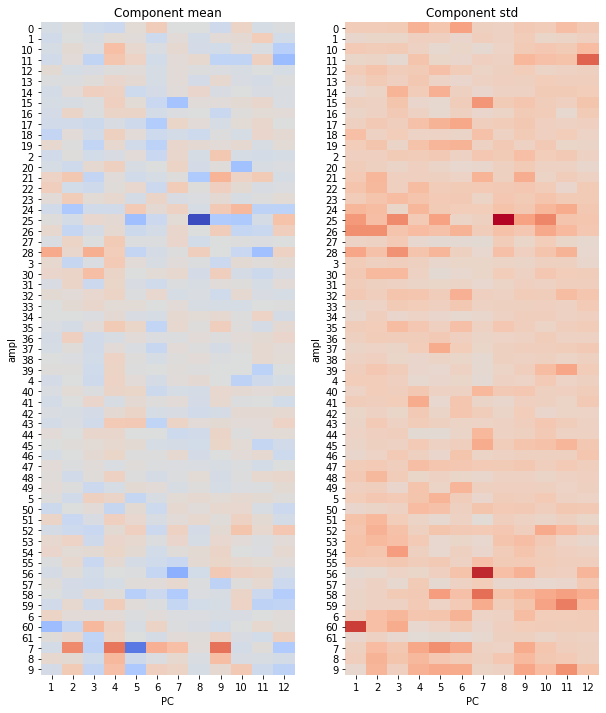

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 12))
sns.heatmap(components.groupby('ampl').mean().iloc[:, :12],
            center=0, cmap='coolwarm', cbar=False, ax=axs[0])
sns.heatmap(components.groupby('ampl').std().iloc[:, :12],
            center=0, cmap='coolwarm', cbar=False, ax=axs[1])
for i in range(2):
    axs[i].set_xlabel('PC');
axs[0].set_title('Component mean')
axs[1].set_title('Component std');